![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
----
# Dialogue Summarization with DistilBERT Encoder + DistilGPT-2 Decoder
----
## BLUF (Bottom Line Up Front)
- Messaging platforms overload users with long group chats; users need **short, reliable summaries**.
- We use the **SAMSum** dataset (chat dialogue + human-written summary) to train a summarization model.
- Architecture: **DistilBERT encoder** (`distilbert-base-uncased`) + **DistilGPT-2 decoder** (`distilgpt2`) in an encoder–decoder setup.
- We analyze the data (lengths, n-grams, structure), then fine-tune the model and evaluate with **ROUGE**.
- Goal: produce summaries that capture the main decisions/events in each conversation in just a few lines.

## 1. Imports and Setup

In [1]:
import os
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

from datasets import load_dataset, Dataset
from sklearn.feature_extraction.text import CountVectorizer

import torch

from transformers import (
    RobertaTokenizerFast,
    GPT2TokenizerFast,
    EncoderDecoderModel,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

import evaluate

/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reproducibility and device

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2. Config

In [3]:
# Data + training config
MAX_SOURCE_LEN = 512      # dialogue max tokens
MAX_TARGET_LEN = 64       # summary max tokens
SMALL_DEBUG_SUBSET = False  # set True for quick smoke tests

# BATCH_SIZE = 2             # keep small for 16GB with gpt2-medium
# NUM_EPOCHS = 3
# LEARNING_RATE = 5e-5

BATCH_SIZE = 4                 # fits comfortably on 16GB with distil models
GRAD_ACCUM_STEPS = 2           # effective batch size = 8
NUM_EPOCHS = 8                 # sweet spot for warm-started cross-attn
LEARNING_RATE = 5e-5           # stable for seq2seq fine-tuning
WARMUP_STEPS = 500             # helps random cross-attention stabilize
WEIGHT_DECAY = 0.01
LOGGING_STEPS = 50



#MODEL_ENCODER_NAME = "roberta-base"
#MODEL_DECODER_NAME = "gpt2-medium"

MODEL_ENCODER_NAME = "distilbert-base-uncased"
MODEL_DECODER_NAME = "distilgpt2"

OUTPUT_DIR = "./outputs_roberta_gpt2_medium"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Load SAMSum and Basic Dataset Peek

In [4]:
samsum = load_dataset("knkarthick/samsum")
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})

In [5]:
# Convert to pandas for easier EDA (train only for now)
train_df = samsum["train"].to_pandas()
val_df = samsum["validation"].to_pandas()
test_df = samsum["test"].to_pandas()

train_df.head()

,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\nJ...,Amanda baked cookies and will bring Jerry some...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,13681000,"Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...",Kim may try the pomodoro technique recommended...
3,13730747,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,13728094,Sam: hey overheard rick say something\nSam: i...,"Sam is confused, because he overheard Rick com..."


In [6]:
# Quick stats
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nColumns:", train_df.columns.tolist())

Train size: 14731
Validation size: 818
Test size: 819

Columns: ['id', 'dialogue', 'summary']


In [7]:
# Show a couple of examples
for i in range(2):
    print(f"---- Example {i} ----")
    print("DIALOGUE:\n", train_df.loc[i, "dialogue"])
    print("\nSUMMARY:\n", train_df.loc[i, "summary"])
    print("\n" + "="*80 + "\n")

---- Example 0 ----
DIALOGUE:
 Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

SUMMARY:
 Amanda baked cookies and will bring Jerry some tomorrow.


---- Example 1 ----
DIALOGUE:
 Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great

SUMMARY:
 Olivia and Olivier are voting for liberals in this election. 




## 4. EDA – Conversation Structure and Lengths
We'll look at:
- Turns per conversation
- Number of speakers
- Lengths (chars, words) of dialogues and summaries
- Compression ratio (summary length / dialogue length)

In [8]:
def parse_dialogue_turns(dialogue: str):
    """
    Split a SAMSum dialogue into (speaker, utterance) pairs.
    Each line looks like: 'Speaker: text...'
    """
    turns = []
    for line in dialogue.split("\n"):
        line = line.strip()
        if not line:
            continue
        if ":" in line:
            speaker, utt = line.split(":", 1)
            turns.append((speaker.strip(), utt.strip()))
        else:
            # fallback: no explicit speaker
            turns.append(("UNKNOWN", line))
    return turns

# Add some basic structural features
def add_structure_features(df: pd.DataFrame) -> pd.DataFrame:
    n_turns = []
    n_speakers = []
    for dlg in df["dialogue"]:
        turns = parse_dialogue_turns(dlg)
        speakers = {spk for spk, _ in turns}
        n_turns.append(len(turns))
        n_speakers.append(len(speakers))
    df = df.copy()
    df["n_turns"] = n_turns
    df["n_speakers"] = n_speakers
    return df

train_df = add_structure_features(train_df)
train_df[["n_turns", "n_speakers"]].describe()

,n_turns,n_speakers
count,14731.000000,14731.000000
mean,11.167266,2.394610
std,6.452542,0.828921
min,3.000000,2.000000
25%,6.000000,2.000000
50%,10.000000,2.000000
75%,15.000000,3.000000
max,46.000000,14.000000


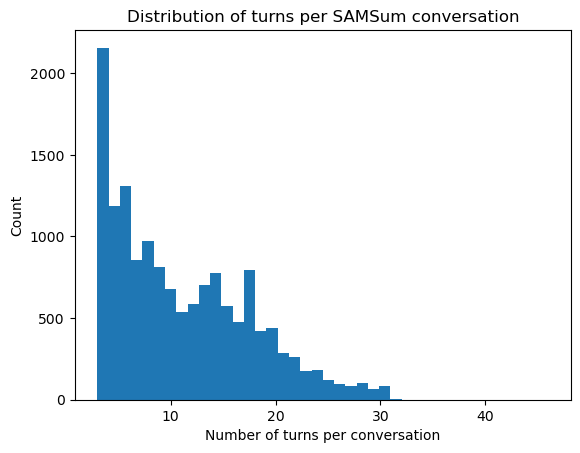

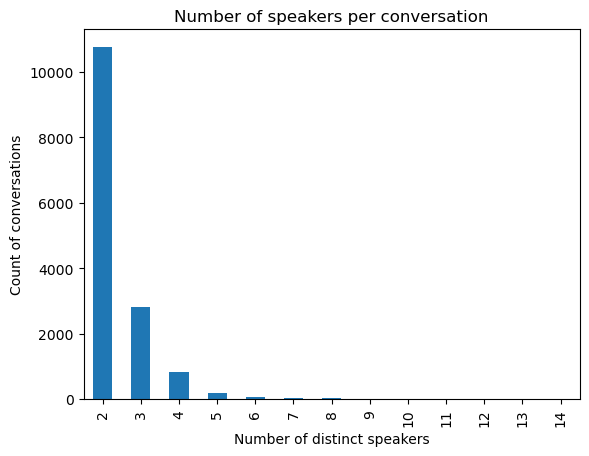

In [9]:
# %%
# Plot distribution of turns per conversation
plt.figure()
train_df["n_turns"].plot(kind="hist", bins=40)
plt.xlabel("Number of turns per conversation")
plt.ylabel("Count")
plt.title("Distribution of turns per SAMSum conversation")
plt.show()

# Plot distribution of speakers
plt.figure()
train_df["n_speakers"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Number of distinct speakers")
plt.ylabel("Count of conversations")
plt.title("Number of speakers per conversation")
plt.show()

In [10]:
# Length features (chars and naive words)
def add_length_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["dialogue_char_len"] = df["dialogue"].str.len()
    df["summary_char_len"] = df["summary"].str.len()
    df["dialogue_word_len"] = df["dialogue"].str.split().str.len()
    df["summary_word_len"] = df["summary"].str.split().str.len()
    df["compression_ratio_words"] = df["summary_word_len"] / df["dialogue_word_len"]
    return df

train_df = add_length_features(train_df)
train_df[["dialogue_word_len", "summary_word_len", "compression_ratio_words"]].describe()

,dialogue_word_len,summary_word_len,compression_ratio_words
count,14731.000000,14731.000000,14731.000000
mean,93.792750,20.318444,0.295947
std,74.031937,11.153570,0.175506
min,7.000000,1.000000,0.015385
25%,39.000000,12.000000,0.170213
50%,73.000000,18.000000,0.256410
75%,128.000000,27.000000,0.379310
max,803.000000,64.000000,1.888889


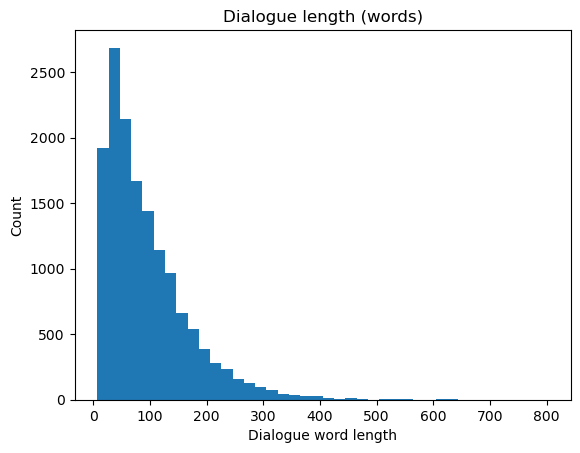

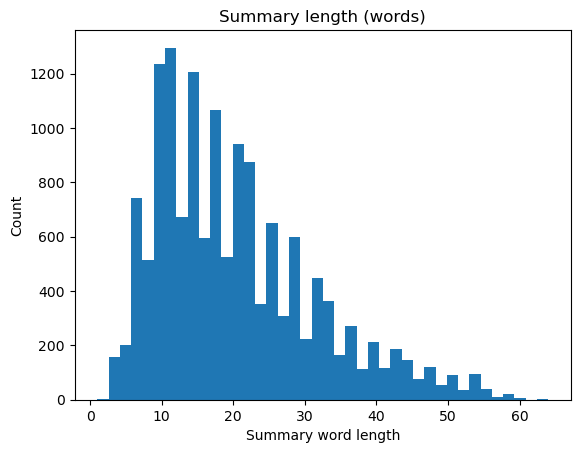

In [11]:
# Histograms of dialogue and summary word lengths
plt.figure()
train_df["dialogue_word_len"].plot(kind="hist", bins=40)
plt.xlabel("Dialogue word length")
plt.ylabel("Count")
plt.title("Dialogue length (words)")
plt.show()

plt.figure()
train_df["summary_word_len"].plot(kind="hist", bins=40)
plt.xlabel("Summary word length")
plt.ylabel("Count")
plt.title("Summary length (words)")
plt.show()

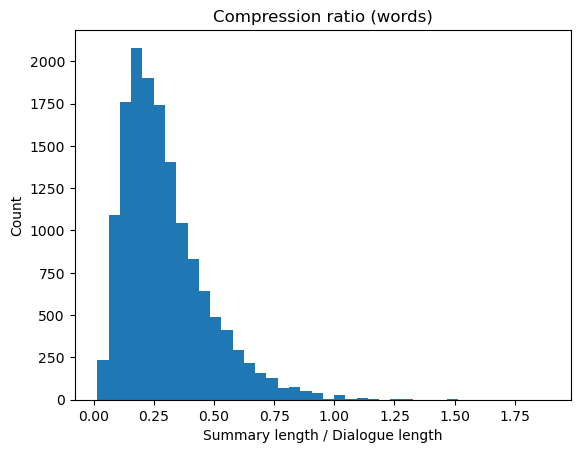

In [12]:
# Compression ratio distribution
plt.figure()
train_df["compression_ratio_words"].plot(kind="hist", bins=40)
plt.xlabel("Summary length / Dialogue length")
plt.ylabel("Count")
plt.title("Compression ratio (words)")
plt.show()

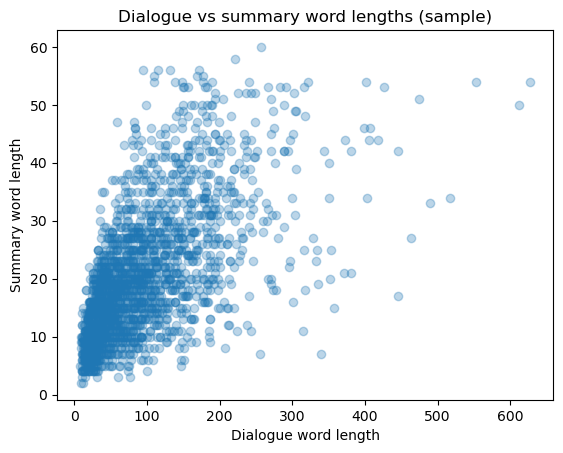

In [13]:
# Dialogue vs summary length scatter (sample for speed)
sample = train_df.sample(n=min(2000, len(train_df)), random_state=SEED)

plt.figure()
plt.scatter(sample["dialogue_word_len"], sample["summary_word_len"], alpha=0.3)
plt.xlabel("Dialogue word length")
plt.ylabel("Summary word length")
plt.title("Dialogue vs summary word lengths (sample)")
plt.show()

## 5. EDA – Unigrams, Bigrams, and Trigrams
We'll compare frequent n-grams in dialogues vs summaries.
We'll do this on a subset for speed.

In [14]:
NGRAM_SAMPLE_SIZE = 5000  # number of rows to use for n-gram EDA
ngram_df = train_df.sample(
    n=min(NGRAM_SAMPLE_SIZE, len(train_df)), random_state=SEED
)

dialogue_corpus = ngram_df["dialogue"].tolist()
summary_corpus = ngram_df["summary"].tolist()

In [15]:
# %%
def top_ngrams(corpus, ngram_range=(1, 1), top_k=20, stop_words="english"):
    """
    Return (ngrams, counts) as lists for the top_k n-grams.
    """
    vectorizer = CountVectorizer(
        ngram_range=ngram_range,
        stop_words=stop_words,
        lowercase=True,
        max_df=0.95,
        min_df=2,
    )
    X = vectorizer.fit_transform(corpus)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vectorizer.get_feature_names_out())
    idx = np.argsort(freqs)[::-1][:top_k]
    return vocab[idx], freqs[idx]

In [16]:
def plot_top_ngrams(ngrams, counts, title):
    plt.figure(figsize=(8, 5))
    idx = np.arange(len(ngrams))
    plt.barh(idx, counts)
    plt.yticks(idx, ngrams)
    plt.xlabel("Count")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### 5.1 Unigrams

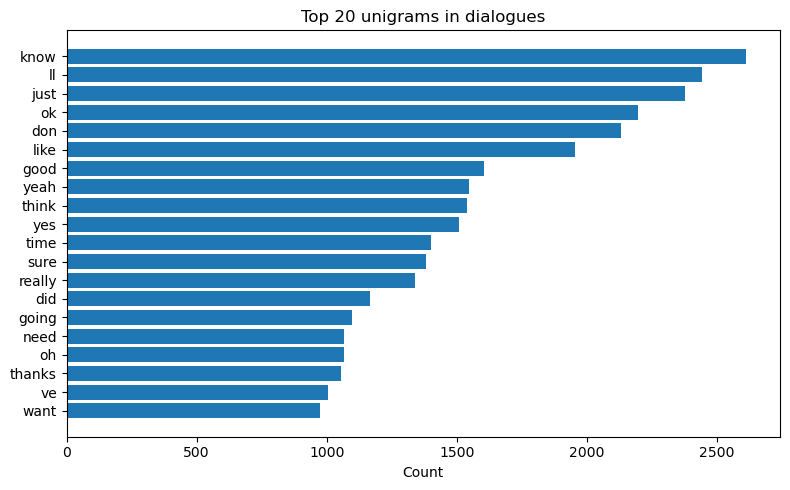

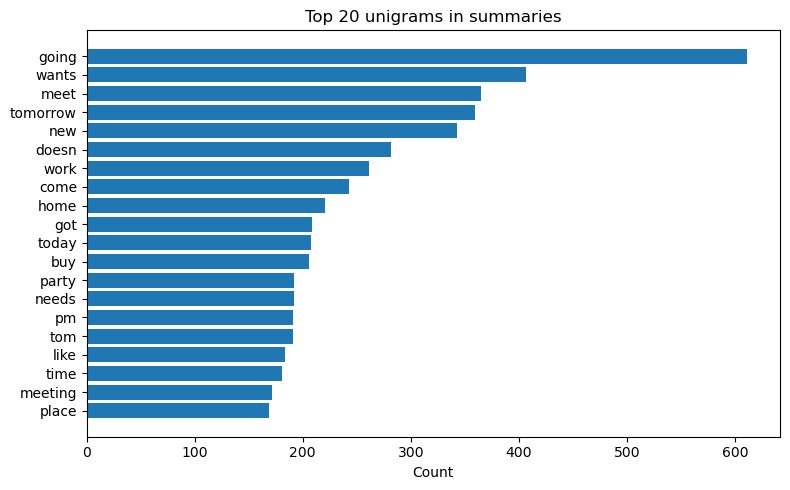

In [17]:
# %%
uni_dlg, uni_dlg_counts = top_ngrams(dialogue_corpus, (1, 1), top_k=20)
plot_top_ngrams(uni_dlg, uni_dlg_counts, "Top 20 unigrams in dialogues")

uni_sum, uni_sum_counts = top_ngrams(summary_corpus, (1, 1), top_k=20)
plot_top_ngrams(uni_sum, uni_sum_counts, "Top 20 unigrams in summaries")

### 5.2 Bigrams

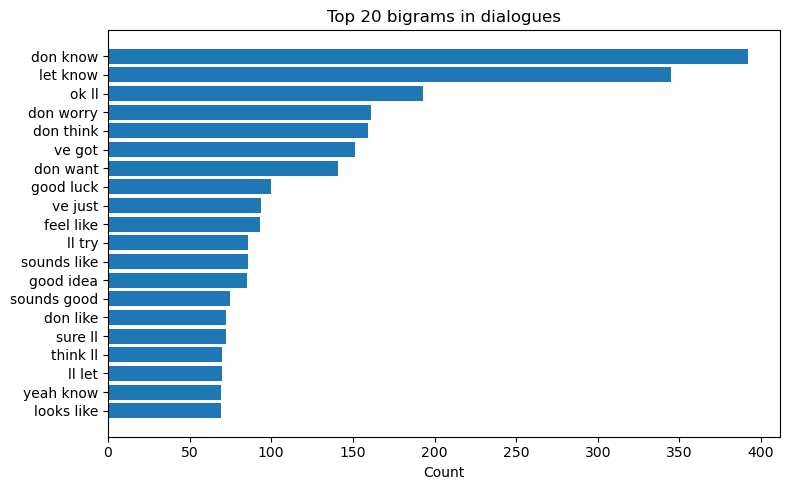

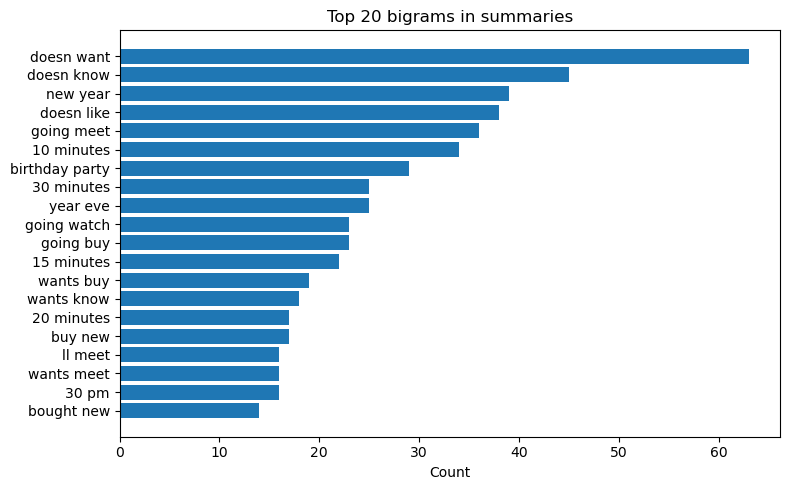

In [18]:
# %%
bi_dlg, bi_dlg_counts = top_ngrams(dialogue_corpus, (2, 2), top_k=20)
plot_top_ngrams(bi_dlg, bi_dlg_counts, "Top 20 bigrams in dialogues")

bi_sum, bi_sum_counts = top_ngrams(summary_corpus, (2, 2), top_k=20)
plot_top_ngrams(bi_sum, bi_sum_counts, "Top 20 bigrams in summaries")

### 5.3 Trigrams

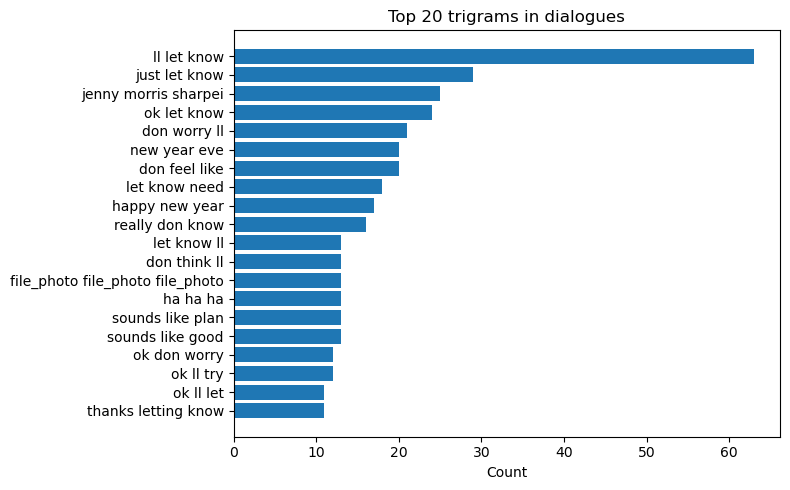

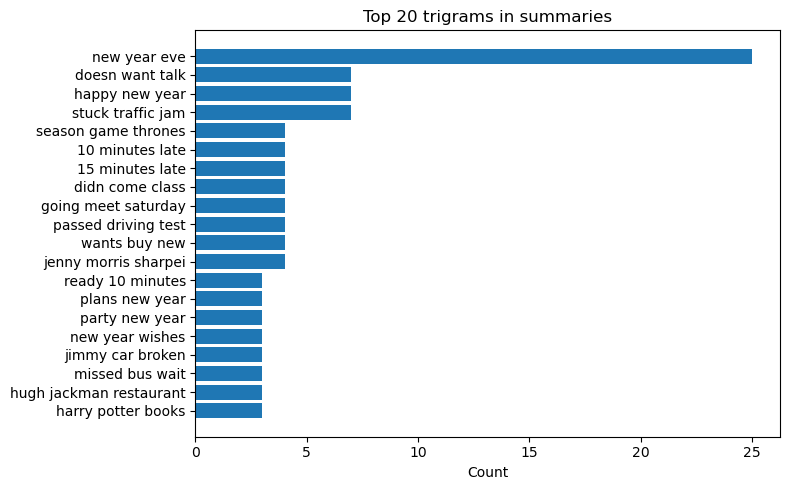

In [19]:
tri_dlg, tri_dlg_counts = top_ngrams(dialogue_corpus, (3, 3), top_k=20)
plot_top_ngrams(tri_dlg, tri_dlg_counts, "Top 20 trigrams in dialogues")

tri_sum, tri_sum_counts = top_ngrams(summary_corpus, (3, 3), top_k=20)
plot_top_ngrams(tri_sum, tri_sum_counts, "Top 20 trigrams in summaries")

At this point, we have a decent picture of:
- Conversation length and structure
- Typical words and phrases in chats vs summaries

Next: build the encoder–decoder pipeline.

## 6. Tokenizers and Data Preparation for DistilBERT → DistilGPT-2

We'll use:
- a **BERT-family encoder** tokenizer for **inputs** (dialogues) — here `distilbert-base-uncased`
- a **GPT-2-family decoder** tokenizer for **outputs** (summaries) — here `distilgpt2`

Because encoder and decoder use different vocabularies, we keep two tokenizers and
build a preprocessing function that returns:
- `input_ids`, `attention_mask`  (encoder)
- `labels`                       (decoder)

In [20]:


enc_tokenizer = AutoTokenizer.from_pretrained(MODEL_ENCODER_NAME, use_fast=True)
dec_tokenizer = AutoTokenizer.from_pretrained(MODEL_DECODER_NAME, use_fast=True)
# GPT-2 has no pad token by default; add one
if dec_tokenizer.pad_token is None:
    dec_tokenizer.add_special_tokens({"pad_token": "[PAD]"})

# Use EOS as both EOS and BOS for decoder; you could add a distinct BOS if you want.
if dec_tokenizer.eos_token is None:
    # usually gpt2 has eos_token=''
    dec_tokenizer.eos_token = dec_tokenizer.special_tokens_map.get("eos_token", "")

dec_tokenizer.bos_token = dec_tokenizer.eos_token

enc_tokenizer, dec_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padd

In [21]:

enc_tokenizer = AutoTokenizer.from_pretrained(MODEL_ENCODER_NAME, use_fast=True)
dec_tokenizer = AutoTokenizer.from_pretrained(MODEL_DECODER_NAME, use_fast=True)
# GPT-2 has no pad token by default; add one
if dec_tokenizer.pad_token is None:
    dec_tokenizer.add_special_tokens({"pad_token": "[PAD]"})

# Use EOS as both EOS and BOS for decoder; you could add a distinct BOS if you want.
if dec_tokenizer.eos_token is None:
    # usually gpt2 has eos_token=''
    dec_tokenizer.eos_token = dec_tokenizer.special_tokens_map.get("eos_token", "")

dec_tokenizer.bos_token = dec_tokenizer.eos_token

enc_tokenizer, dec_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padd

### 6.1 Hugging Face Dataset → Tokenized Datasets
We'll make a function that:
- Takes `dialogue` and `summary`
- Encodes them with the respective tokenizer
- Truncates/pads to fixed length

In [22]:
def preprocess_function(batch):
    # Encoder: RoBERTa on the dialogue
    enc = enc_tokenizer(
        batch["dialogue"],
        padding="max_length",
        truncation=True,
        max_length=MAX_SOURCE_LEN,
    )

    # Decoder: GPT-2 on the summary
    with dec_tokenizer.as_target_tokenizer():
        dec = dec_tokenizer(
            batch["summary"],
            padding="max_length",
            truncation=True,
            max_length=MAX_TARGET_LEN,
        )

    # Replace PAD token id with -100 for labels (ignored in loss)
    labels = np.array(dec["input_ids"])
    labels[labels == dec_tokenizer.pad_token_id] = -100

    out = {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": labels,
    }
    return out

In [23]:
tokenized_train = samsum["train"]
tokenized_val = samsum["validation"]

if SMALL_DEBUG_SUBSET:
    tokenized_train = tokenized_train.select(range(512))
    tokenized_val = tokenized_val.select(range(128))

tokenized_train = tokenized_train.map(
    preprocess_function,
    batched=True,
    remove_columns=["id", "dialogue", "summary"],
)
tokenized_val = tokenized_val.map(
    preprocess_function,
    batched=True,
    remove_columns=["id", "dialogue", "summary"],
)

tokenized_train[0]

{'input_ids': [101,
  8282,
  1024,
  1045,
  17776,
  16324,
  1012,
  2079,
  2017,
  2215,
  2070,
  1029,
  6128,
  1024,
  2469,
  999,
  8282,
  1024,
  1045,
  1005,
  2222,
  3288,
  2017,
  4826,
  1024,
  1011,
  1007,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

## 7. Build DistilBERT → DistilGPT-2 Encoder–Decoder Model

We'll use `EncoderDecoderModel.from_encoder_decoder_pretrained` with
`distilbert-base-uncased` as the encoder and `distilgpt2` as the decoder. Then we:

- Move the model to the selected device (CPU/GPU).
- Resize the decoder embeddings (we added a PAD token).
- Set important generation/config values (BOS/EOS, padding, `max_length`, `num_beams`).

In [24]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    MODEL_ENCODER_NAME,
    MODEL_DECODER_NAME,
)

# Resize decoder embeddings to reflect added pad token
model.decoder.resize_token_embeddings(len(dec_tokenizer))

model.config.decoder_start_token_id = dec_tokenizer.bos_token_id
model.config.eos_token_id = dec_tokenizer.eos_token_id
model.config.pad_token_id = dec_tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

# Some generation defaults
model.config.max_length = MAX_TARGET_LEN
model.config.num_beams = 4

model = model.to(device)
model.config

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.2.cr

EncoderDecoderConfig {
  "decoder": {
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "dtype": "float32",
    "embd_pdrop": 0.1,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "label2id": {
      "LABEL_0": 0
    },
    "layer_norm_epsilon": 1e-05,
    "model_type": "gpt2",
    "n_ctx": 1024,
    "n_embd": 768,
    "n_head": 12,
    "n_inner": null,
    "n_layer": 6,
    "n_positions": 1024,
    "reorder_and_upcast_attn": false,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": false,
    "scale_attn_weights": true,
    "summary_activation": null,
    "summary_first_dropout": 0.1,
    "summary_proj_to_labels": true,
    "summary_type": "cls_index",
    "summary_use_proj": true,
    "task_specific_params": {
      "text-generation": {
        "do_sample": tr

## 8. Data Collator and ROUGE Metric
We'll use `DataCollatorForSeq2Seq` to dynamically pad batches,
and `evaluate`'s ROUGE implementation for metrics.

In [25]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer=dec_tokenizer,  # used for padding labels; inputs already same length
    model=model,
    label_pad_token_id=-100,
)

rouge = evaluate.load("rouge")

In [26]:
def postprocess_text(preds, labels):
    preds = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels


def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # --- FIX START ---
    # Replace -100 in the predictions as well, as Seq2SeqTrainer pads predictions
    # with -100 to handle variable generation lengths across batches.
    preds = np.where(preds != -100, preds, dec_tokenizer.pad_token_id)
    # --- FIX END ---

    # Replace -100 back to pad_token_id so we can decode labels
    labels = np.where(labels != -100, labels, dec_tokenizer.pad_token_id)

    # Decode
    decoded_preds = dec_tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = dec_tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
    )
    # Convert to percent
    result = {k: round(v * 100, 2) for k, v in result.items()}
    return result

## 9. Training Setup (Trainer API)

We configure `Seq2SeqTrainer` to fine-tune the DistilBERT → DistilGPT-2 model on SAMSum.

Key choices here:

- **Batching:** small per-device batch size with `gradient_accumulation_steps` to get an effective batch of 8.
- **Schedule:** `warmup_steps` + weight decay to help stabilize the newly initialized cross-attention.
- **Objective:** `load_best_model_at_end=True`, selecting by ROUGE-L.
- **Generation:** we use beam search during evaluation (`generation_num_beams=4`, `generation_max_length=64`).

On a 16GB GPU, this setup is much more manageable than a full `roberta-base` → `gpt2-medium` run, while still following the “BERT-style encoder + GPT-2-style decoder” assignment.

In [27]:
# training_args = Seq2SeqTrainingArguments(
#     output_dir=OUTPUT_DIR,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     logging_strategy="steps",
#     logging_steps=100,
#     per_device_train_batch_size=BATCH_SIZE,
#     per_device_eval_batch_size=BATCH_SIZE,
#     learning_rate=LEARNING_RATE,
#     num_train_epochs=NUM_EPOCHS,
#     weight_decay=0.01,
#     predict_with_generate=True,
#     fp16=torch.cuda.is_available(),
#     load_best_model_at_end=True,
#     metric_for_best_model="rougeL",
#     greater_is_better=True,
# )


training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=LOGGING_STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    save_total_limit=2,            # keeps checkpoints manageable
    generation_max_length=64,      # your summary length cap
    generation_num_beams=4,
)

In [28]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=dec_tokenizer,  # used for generation
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_595190/2707929255.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


### 9.1 Train (this is the heavy cell)

Run this once you're happy with the setup.

For faster iteration:

- set `SMALL_DEBUG_SUBSET = True`
- reduce `NUM_EPOCHS`
- or temporarily switch to an even smaller configuration before scaling back up

The current settings (DistilBERT + DistilGPT-2, 8 epochs, warmup, and gradient accumulation)
are a good “sweet spot” for seeing non-trivial ROUGE scores without completely melting the GPU.

In [29]:
# Uncomment to train
train_result = trainer.train()
trainer.save_model(OUTPUT_DIR)
trainer.save_model(os.path.join(OUTPUT_DIR, "best")) 
trainer.save_state()
train_result

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 50256, 'pad_token_id': 50257}.
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/models/distilbert/modeling_distilbert.py:392: UserWarning: Using AOTriton backend for Efficient Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention.hip:1180.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/integrations/sdpa_attention.py:96: UserWarning: Using AOTriton backend for Flash Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/flash_attn/flash_api.h:267.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/timnevits/minic

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,6.989600,3.354305,19.800000,4.380000,16.740000,16.750000
2,6.109900,3.108165,25.000000,6.860000,20.980000,21.000000
3,5.114200,2.975314,29.540000,9.250000,24.610000,24.580000
4,4.478100,2.895598,32.700000,11.170000,26.920000,26.940000
5,4.016300,2.935730,34.260000,11.820000,28.010000,28.010000
6,3.634700,2.987206,35.440000,12.220000,28.590000,28.590000
7,3.207900,3.054286,35.490000,12.940000,29.040000,29.040000
8,3.079400,3.103293,36.440000,13.210000,29.620000,29.580000


/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'num_beams': 4}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:575: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/home/timnevits/miniconda3/envs/rocm312/lib/python3.1

TrainOutput(global_step=14736, training_loss=4.66103406630691, metrics={'train_runtime': 2725.4729, 'train_samples_per_second': 43.239, 'train_steps_per_second': 5.407, 'total_flos': 3.592811106533376e+16, 'train_loss': 4.66103406630691, 'epoch': 8.0})

## 10. Evaluation and Sample Summaries
We'll:
- Evaluate ROUGE on the validation set (if not already done during training).
- Generate summaries for a few random examples and inspect them.

In [30]:
# Uncomment after training
metrics = trainer.evaluate()
metrics

/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:575: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


{'eval_loss': 3.10329270362854,
 'eval_rouge1': 36.44,
 'eval_rouge2': 13.21,
 'eval_rougeL': 29.62,
 'eval_rougeLsum': 29.58,
 'eval_runtime': 101.7939,
 'eval_samples_per_second': 8.036,
 'eval_steps_per_second': 2.014,
 'epoch': 8.0}

In [31]:
def generate_summary_for_index(idx: int):
    row = samsum["validation"][idx]
    dialogue = row["dialogue"]
    reference = row["summary"]

    # Encode dialogue with encoder tokenizer
    enc_inputs = enc_tokenizer(
        dialogue,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_SOURCE_LEN,
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            **enc_inputs,
            max_length=MAX_TARGET_LEN,
            num_beams=4,
            early_stopping=True,
        )

    pred = dec_tokenizer.decode(
        generated_ids[0],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    )

    print("---- DIALOGUE ----")
    print(dialogue)
    print("\n---- REFERENCE SUMMARY ----")
    print(reference)
    print("\n---- MODEL SUMMARY ----")
    print(pred)


# Example usage (after training)
generate_summary_for_index(0)

---- DIALOGUE ----
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-) 
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would like?
A: Oh, yes, I took him there last Monday. He showed me one that he really liked.
B: I bet you had to drag him away.
A: He wanted to take it home right away ;-).
B: I wonder what he'll name it.
A: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))

---- REFERENCE SUMMARY ----
A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy. 

---- MODEL SUMMARY 

## 11. Notes, Limitations, and Next Steps

**What we've done in this notebook:**

- Explored the SAMSum dataset:
  - Turn counts and speaker counts
  - Length and compression-ratio distributions
  - Frequent unigrams, bigrams, and trigrams in dialogues vs summaries
- Built a **two-tower encoder–decoder** model:
  - Encoder: `distilbert-base-uncased` (BERT-family encoder)
  - Decoder: `distilgpt2` (GPT-2-family decoder)
- Set up a training pipeline using Hugging Face `Seq2SeqTrainer` and ROUGE metrics.
- Generated sample summaries on the validation set to sanity-check behavior.

**Limitations / rough edges:**

- Even with Distil models, full-dataset training is not “instant” on consumer GPUs.
- Truncating dialogues to `MAX_SOURCE_LEN` can drop context in longer chats.
- ROUGE focuses on surface-level overlap, not deeper semantic quality or factuality.
- Cross-attention starts from random initialization; it still needs enough training steps
  to learn good alignments between dialogues and summaries.

**Potential improvements:**

- Compare against pretrained seq2seq baselines like `facebook/bart-base` or `t5-small`
  as stronger reference points.
- Tune decoding (beam size, repetition penalty, length penalty) for cleaner summaries.
- Add human-style evaluation: rate summaries for coverage, coherence, and faithfulness.
- Experiment with alternative encoder/decoder sizes (e.g., full `bert-base-uncased` or `gpt2`)
  once you’re satisfied with the smaller Distil configuration.

This notebook now gives you a complete pipeline — EDA → DistilBERT/DistilGPT-2 modeling → evaluation — aligned with a BERT+GPT-2 style architecture while remaining trainable on modest hardware.